In [1]:
import numpy as np
from bson import json_util
import helix as hx
from helix import units
import numpy as np
import strax as sx                    
from matplotlib import pyplot as plt
from glob import glob 
import os
import shutil

raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
run = 'run10' 
duration = 10  # seconds
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel 

In [2]:
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
hx.generate_toy_data(run, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


In [3]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin
context.set_config(config)

In [4]:
records = context.get_array(run, 'raw_records')
uv_triggers = context.get_array(run, 'uv_triggers')
qp_triggers = context.get_array(run, 'qp_triggers')
events = context.get_array(run, 'events')
fit_results = context.get_array(run, 'fit_results')  
raw_data = events['channel_data']
noise_psds = context.get_array(run, 'noise_psds')

AttributeError: 'str' object has no attribute 'timestamp'

In [13]:
fit_results['vacuum_channel_uv_amplitude']

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,   -60.17427003, 10445.45151345,   -71.34543251,
        10440.07062809, 10463.50096439,   -33.23355147, 10461.14746564,
        13301.68606764,   -44.36056028,   -58.49014363],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,   -38.68177348, 11456.67421734,   -52.85004891,
          -47.80163243, 10454.5153704 ,   -41.86484798,   -35.2686193 ,
        10444.61653954,   -44.79570351,   -57.65826512],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,   -41.79387428,   -42.22098069,   -37.6222051 ,
          -42.73571502,   -36.28392257, 10465.22122749,   -57.76018596,
        10434.75642135, 10462.05958446,   -33.23499192],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,   -49.97156097, 10457.29335426,   -39.89221951,
        10448.12925423,   -35.8853122

In [14]:
def plot_histogram_of_filtered_amplitudes(fit_results):
    amplitude_values = fit_results['submerged_channel_uv_amplitude'].flatten()
    mask = (amplitude_values >= 10000) & (amplitude_values <= 15000)
    filtered_values = amplitude_values[mask]
    
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_values, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.title('Histogram of Filtered Submerged Channel UV Amplitudes')
    plt.show()

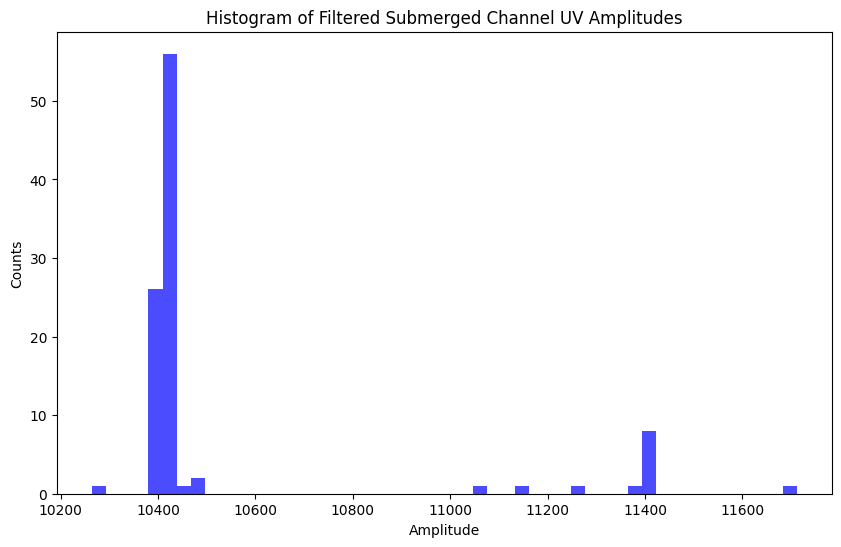

In [15]:
plot_histogram_of_filtered_amplitudes(fit_results)

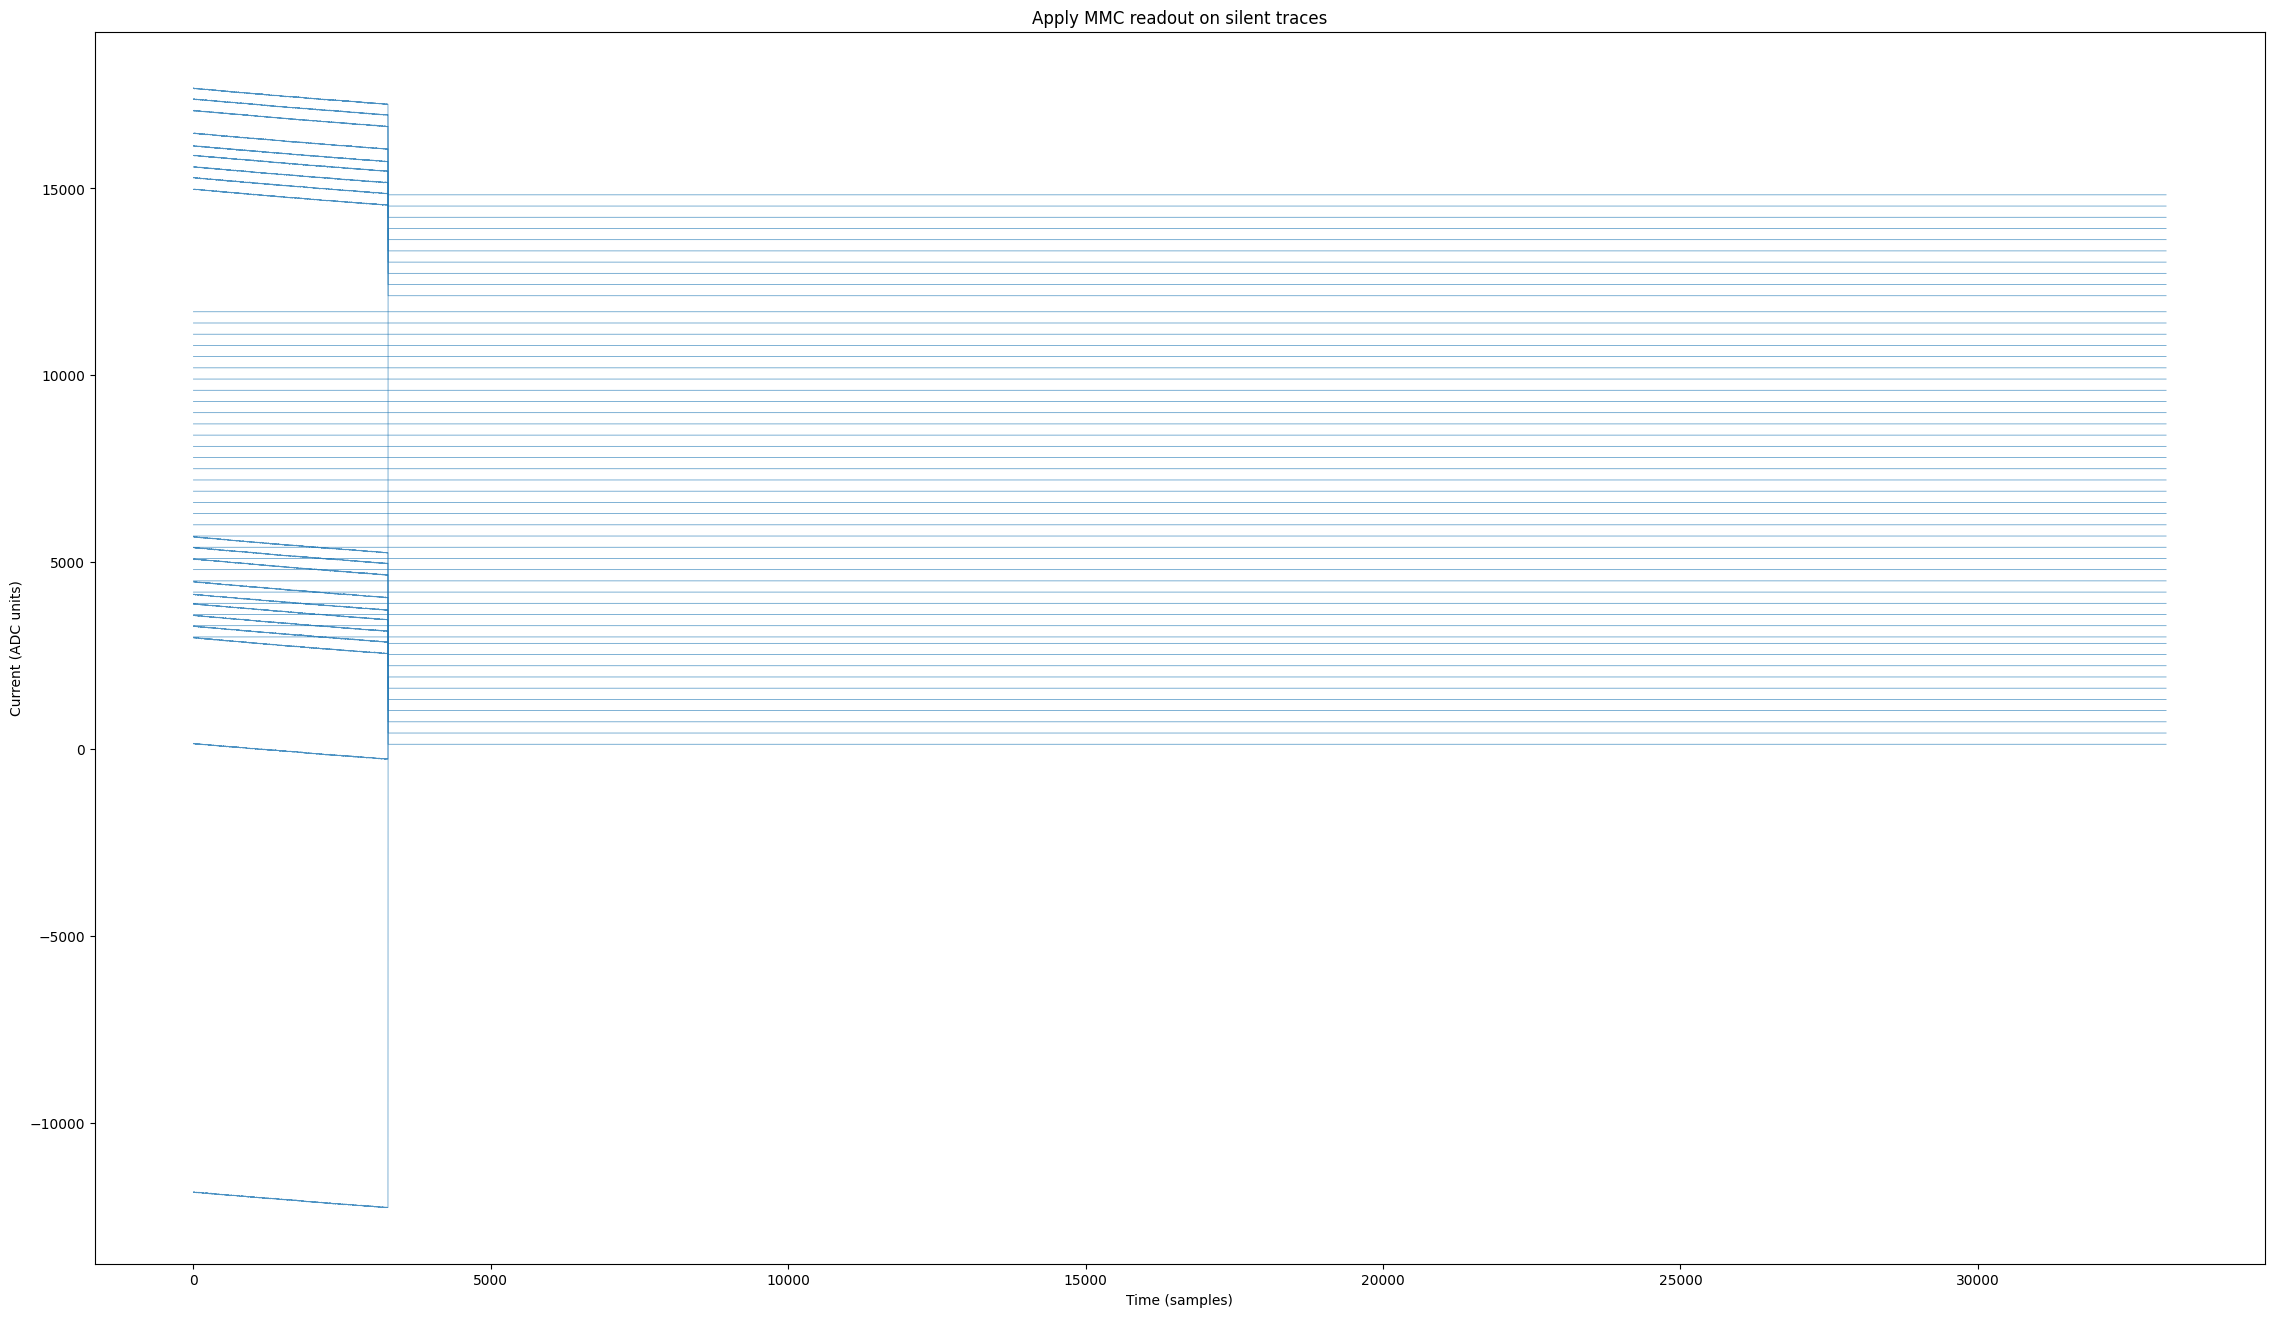

In [18]:
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)



# change this to choose another event if the one below is a bad one by chance
i = 11

plt.figure(figsize=(28,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel


plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Apply MMC readout on silent traces')
#plt.savefig('raw_traces_on_silent_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
events['channel_data'].shape

(12, 50, 33168)

In [10]:
import numpy as np
import pandas as pd

# Assuming events['channel_data'] is a NumPy array with shape (12, 50, 33168)
channel_data = np.array(events['channel_data'])  # Ensure it's a NumPy array

# Reshape into (12, 50, 33168)
reshaped_array = channel_data.reshape(12, 50, 33168)

# Drop indices 5 and 11 (resulting shape: (10, 50, 33168))
filtered_array = np.delete(reshaped_array, [5, 11], axis=0)

# Keep only the first 10 from the second dimension (resulting shape: (10, 10, 33168))
filtered_array = filtered_array[:, :10, :]

# Reshape back to 2D for saving (new shape: (10 * 10, 33168) → (100, 33168))
flattened_array = filtered_array.transpose(1, 0, 2).reshape(100, 33168)

# Convert back to DataFrame
df_filtered = pd.DataFrame(flattened_array)

# Save to CSV
csv_filename = "helix_traces.csv"
df_filtered.to_csv(csv_filename, index=False, header=False)

print(f"Saved filtered CSV file: {csv_filename}")
print(f"New shape after filtering: {filtered_array.shape}")  # Should print (10, 10, 33168)



Saved filtered CSV file: helix_traces.csv
New shape after filtering: (10, 10, 33168)


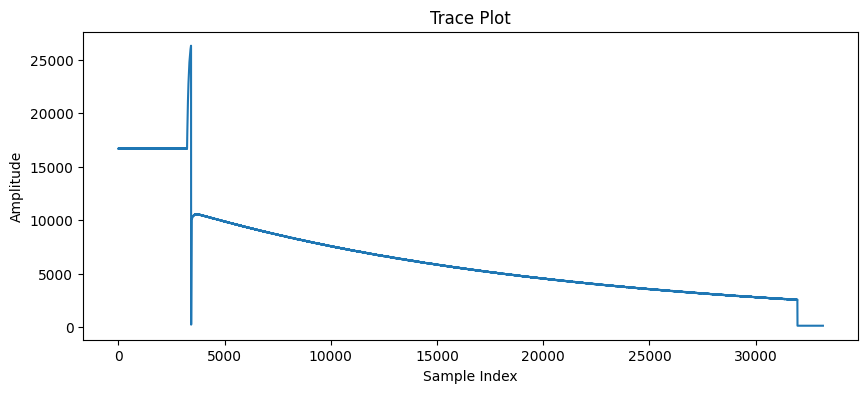

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(flattened_array[70])
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Trace Plot")
plt.show()

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Read the CSV file
csv_filename = "helix_traces.csv"
df = pd.read_csv(csv_filename, header=None)

data_array = df.to_numpy()
data_array.shape

(100, 33168)

In [57]:
def plot_event_traces_from_csv(raw_evt_traces, start_idx=0, end_idx=10):
    """
    Plots a range of traces (each of 33,168 samples) from the CSV file.
    
    Parameters:
        csv_filename (str): Path to the CSV file containing (100, 33168) data.
        start_idx (int): Starting index of traces to plot (default is 0).
        end_idx (int): Ending index of traces to plot (default is 10).
    """

    # Ensure indices are within bounds
    start_idx = max(0, start_idx)
    end_idx = min(raw_evt_traces.shape[0], end_idx)
    
    # Extract the selected traces
    traces = raw_evt_traces[start_idx:end_idx]  # Shape: (N, 33168), where N = end_idx - start_idx

    plt.figure(figsize=(28, 16))

    # Adding artificial baselines to separate traces
    artificial_baselines = np.arange(len(traces)) * 300  
    plt.plot(traces.T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')

    plt.xlabel('Time (samples)')
    plt.ylabel('Current (ADC units)')
    plt.title(f'Traces {start_idx+1} to {end_idx} from CSV file')

    plt.show()


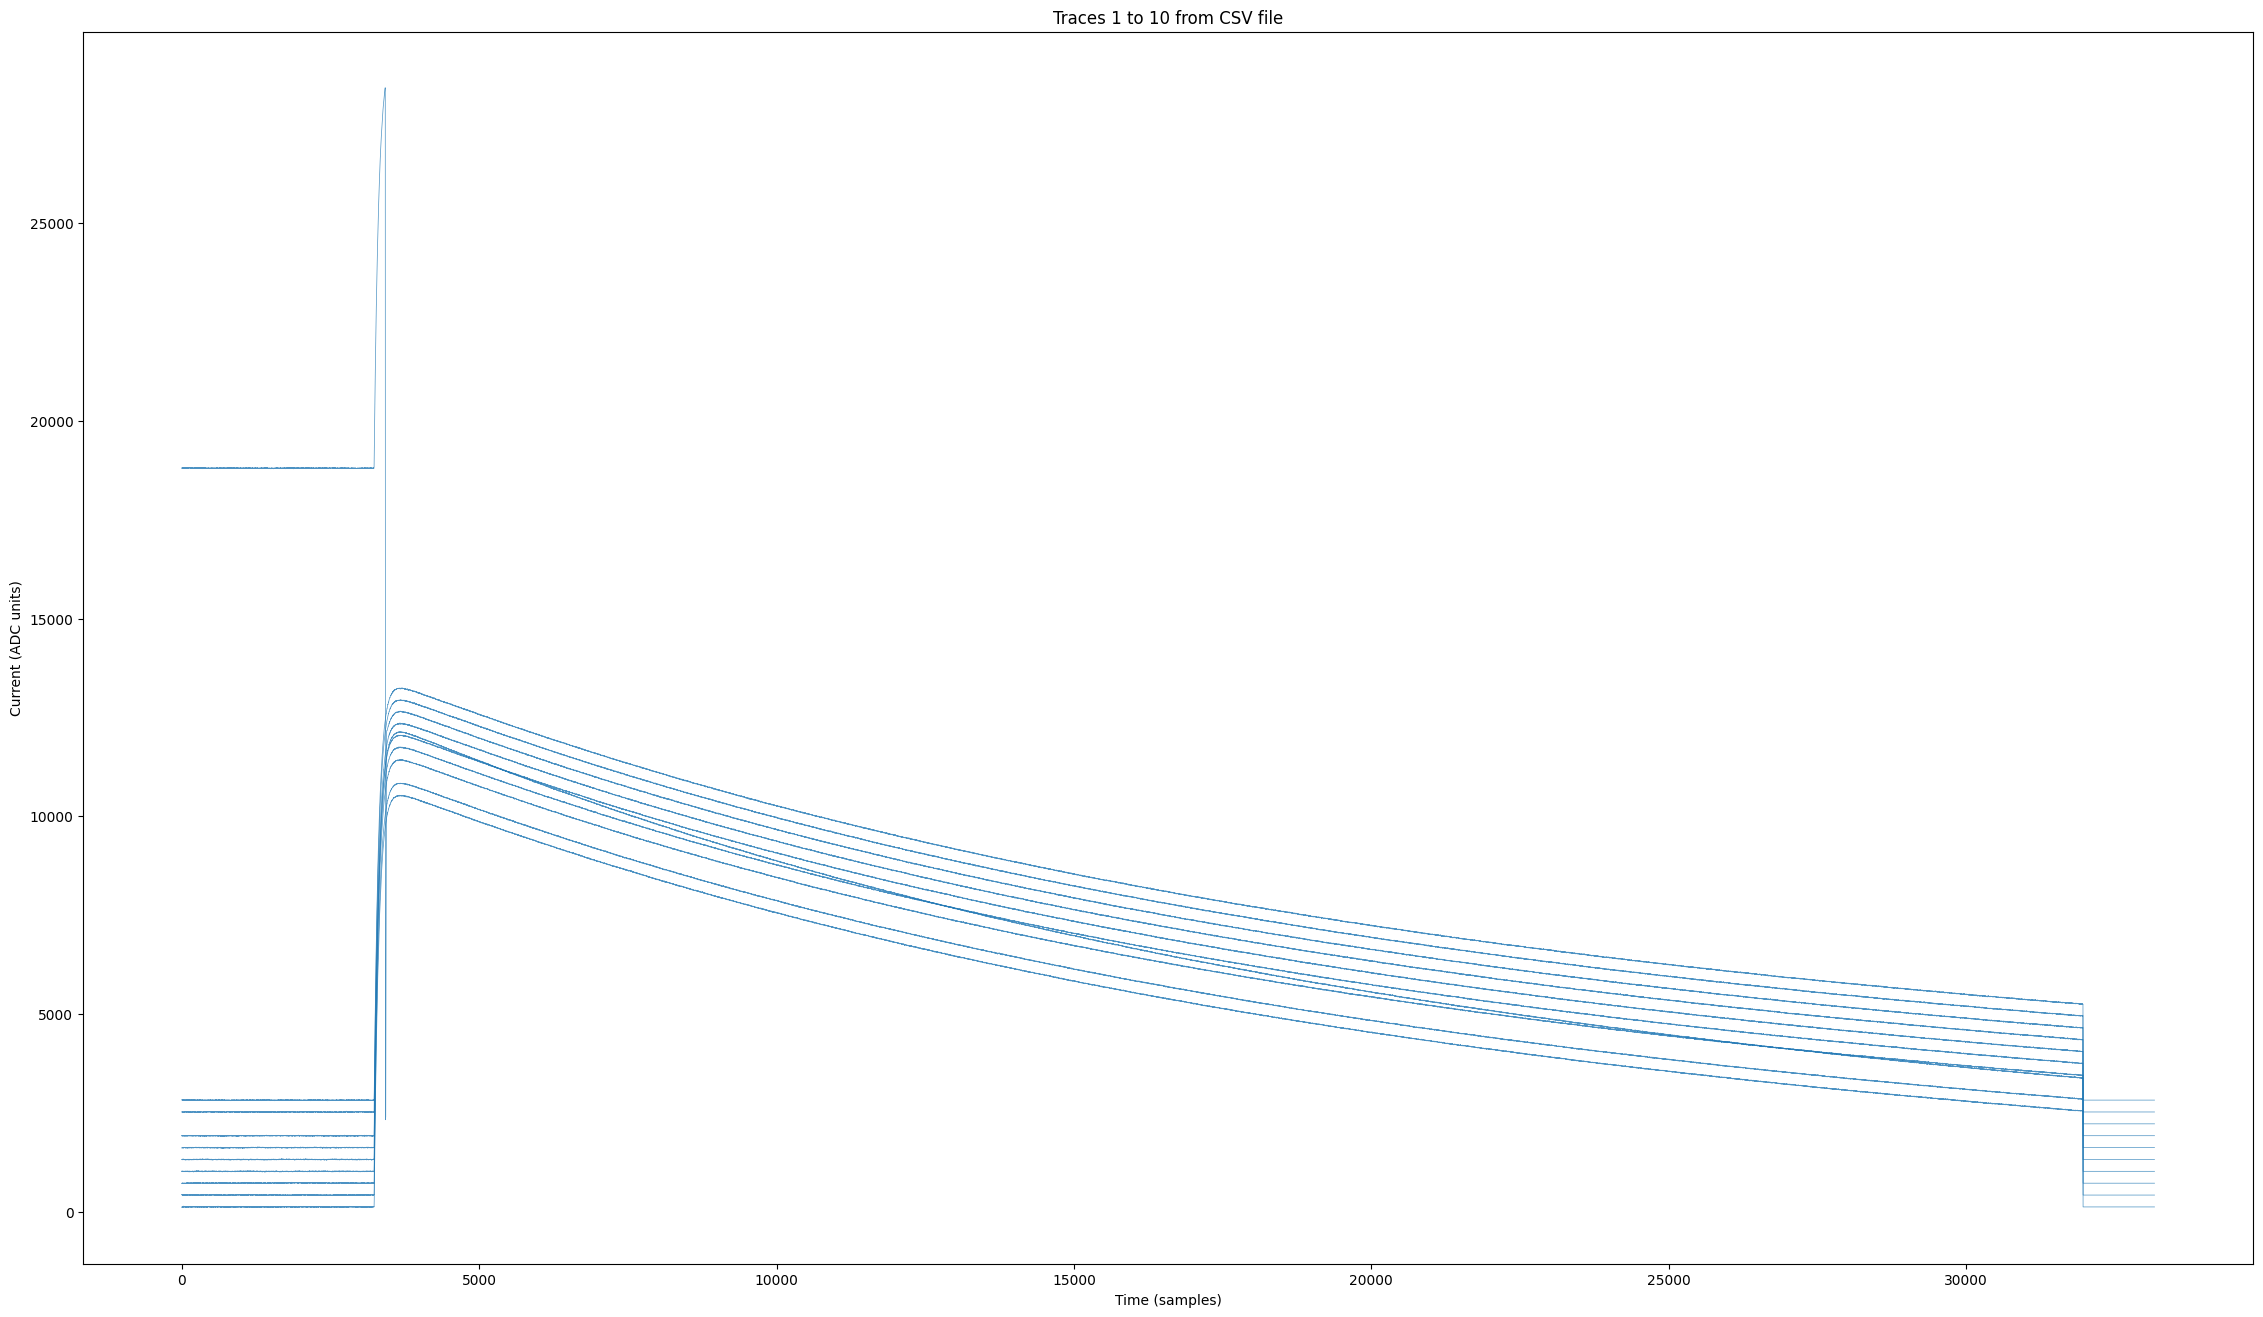

In [58]:
plot_event_traces_from_csv(data_array, start_idx=0, end_idx=10)

In [ ]:
drop 5, 11

In [19]:
3250000/32768

99.18212890625

In [4]:
def view_raw_records(context, run, start_ch, end_ch):
    records = context.get_array(run, 'raw_records')
    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)
    
    selected_channels = [ch for ch in channels if start_ch <= ch <= end_ch]
    
    unique_blocks = np.sort(np.unique(records['block_id']))
    for i in unique_blocks:
        record_mask = records['block_id'] == i
        plt.figure(figsize=(12, 10))
        
        print(f"Plotting channels: {selected_channels[0]} to {selected_channels[-1]}")
        
        for idx, ch in enumerate(selected_channels):  # Plot selected channel range
            mask = record_mask & (records['channel'] == ch)
            record = records['data'][mask][0]
            add_baseline = 300 * idx  # Incremental baseline for visibility
            plt.plot(record + add_baseline, color='C0', lw=0.5)
        
        plt.xlabel('Time (samples)')
        plt.ylabel('Current w/artificial baselines (ADC)')
        plt.ylim(-30000, 20000)  # Fix y-scale from 0 to 20000

        plt.show()
        
        if i >= 3:
            break


Loading raw_records: |              | 0.00 % [00:00<?], #1 (0.04 s). 3094.4 MB/s


Plotting channels: 1 to 50


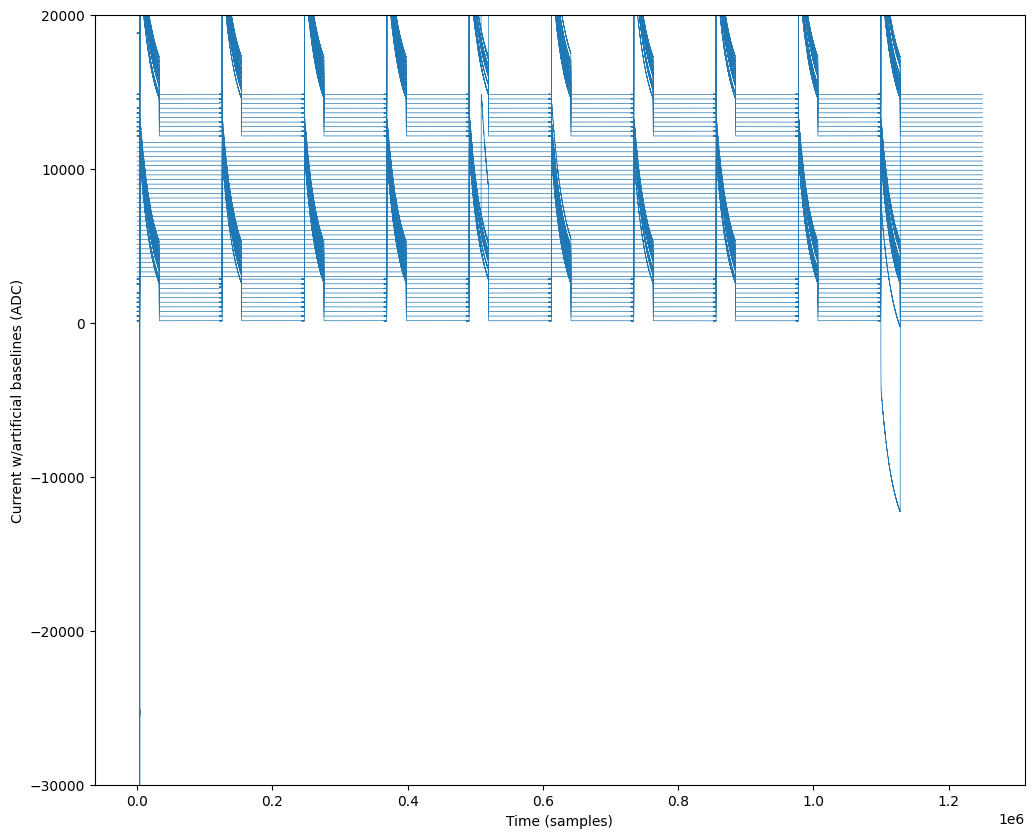

In [6]:
view_raw_records(context, run, 0, 449)